In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import optuna
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
epochs = 200
df = pd.read_excel("train_augmented.xlsx", decimal=',')

features = ['I1', 'I2','I3','gx','gy','gz','ax','ay','az', 'V1real', 'V2real','V3real','N1', 'N2', 'N3']
X = df[features].values.astype(np.float32)
y = df['is_type_2'].values.astype(np.int64)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
df.head()

,I1,I2,I3,gx,gy,gz,ax,ay,az,V1real,V2real,V3real,N1,N2,N3,is_type_2
0,-0.471950,0.550872,1.134162,-0.059573,0.399039,-0.850156,0.140172,0.159185,0.545425,-0.857699,-1.141447,0.409516,-0.897883,-1.219728,0.684431,0
1,-0.775354,-0.546095,-0.896019,0.865303,-1.916572,2.383234,-0.548671,-0.773725,-0.350658,1.872474,1.888301,2.057437,1.879688,1.796098,1.895289,1
2,0.660220,1.621724,0.117663,0.349994,0.882552,-0.898211,-0.085392,-0.303491,-0.044781,-0.077482,-1.150340,-0.855828,-0.027395,-1.180805,-0.827632,0
3,0.789075,-1.229868,0.857876,0.270200,0.692716,-0.711333,0.606434,0.221447,-0.198819,-1.271994,-0.228588,-0.301218,-1.349336,-0.331371,-0.425692,0
4,-0.258840,-0.304050,-0.535496,-0.005931,-0.440801,0.438362,-1.770624,0.379682,0.967249,0.621758,0.624703,0.090047,0.561161,0.618169,-0.070564,0


In [3]:
class SurfaceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
def get_activation(name):
    if name == 'relu':
        return nn.ReLU()
    elif name == 'tanh':
        return nn.Tanh()
    elif name == 'leaky_relu':
        return nn.LeakyReLU()
    elif name == 'elu':
        return nn.ELU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

In [8]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate, activation_name):
        super(Net, self).__init__()
        activation = get_activation(activation_name)
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation)
        layers.append(nn.Dropout(dropout_rate))
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_dim, 2))  # логиты
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

In [9]:
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 4, 100)
    num_layers = trial.suggest_int('num_layers', 2, 4)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    activation_name = trial.suggest_categorical('activation', ['relu', 'tanh', 'leaky_relu', 'elu'])
    
    model = Net(
        input_dim=15,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        activation_name=activation_name
    )
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_y)
    weights = torch.tensor(weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=weights)
    train_loader = DataLoader(SurfaceDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(test_X, dtype=torch.float32)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).numpy()
        f1 = f1_score(test_y, preds)
    return f1

In [10]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=epochs)

print("Best trial:")
print(study.best_trial.params)

[I 2025-06-14 14:21:47,653] A new study created in memory with name: no-name-a023a015-3d7d-4107-b58d-b1aced651394
[I 2025-06-14 14:21:55,774] Trial 0 finished with value: 1.0 and parameters: {'hidden_dim': 23, 'num_layers': 3, 'lr': 0.0007531798271421877, 'dropout_rate': 0.18876167758233664, 'batch_size': 32, 'activation': 'tanh'}. Best is trial 0 with value: 1.0.
[I 2025-06-14 14:22:02,633] Trial 1 finished with value: 1.0 and parameters: {'hidden_dim': 61, 'num_layers': 2, 'lr': 0.0007696887936557849, 'dropout_rate': 0.28839423530330544, 'batch_size': 32, 'activation': 'leaky_relu'}. Best is trial 0 with value: 1.0.
[I 2025-06-14 14:22:09,488] Trial 2 finished with value: 1.0 and parameters: {'hidden_dim': 62, 'num_layers': 2, 'lr': 0.00027171204346472196, 'dropout_rate': 0.13527106423427782, 'batch_size': 32, 'activation': 'elu'}. Best is trial 0 with value: 1.0.
[I 2025-06-14 14:22:16,146] Trial 3 finished with value: 1.0 and parameters: {'hidden_dim': 45, 'num_layers': 2, 'lr': 0.

Best trial:
{'hidden_dim': 23, 'num_layers': 3, 'lr': 0.0007531798271421877, 'dropout_rate': 0.18876167758233664, 'batch_size': 32, 'activation': 'tanh'}


In [11]:
best_params = study.best_trial.params
model = Net(
    input_dim=15,
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers'],
    dropout_rate=best_params['dropout_rate'],
    activation_name=best_params['activation']
)

optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_y)
weights = torch.tensor(weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights)

train_loader = DataLoader(SurfaceDataset(train_X, train_y), batch_size=best_params['batch_size'], shuffle=True)

In [12]:
val_f1_history = []
model.train()

for epoch in range(epochs):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(test_X, dtype=torch.float32)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).numpy()
        f1 = f1_score(test_y, preds)
        val_f1_history.append(f1)


In [13]:
model.eval()
with torch.no_grad():
    inputs = torch.tensor(test_X, dtype=torch.float32)
    outputs = model(inputs)
    preds = torch.argmax(outputs, dim=1).numpy()

print("Final Accuracy:", accuracy_score(test_y, preds))
print("Final F1 Score:", f1_score(test_y, preds))

Final Accuracy: 1.0
Final F1 Score: 1.0


In [14]:
torch.save({
    'model_state_dict': model.state_dict(),
    'params': best_params
}, 'model.pt')
print("Модель сохранена в model.pt")

Модель сохранена в model.pt


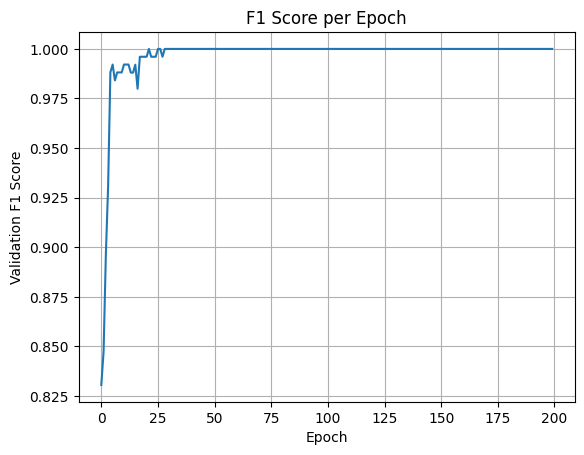

In [15]:
plt.plot(val_f1_history)
plt.xlabel("Epoch")
plt.ylabel("Validation F1 Score")
plt.title("F1 Score per Epoch")
plt.grid(True)
plt.show()
